In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import scipy.stats as stats

import datetime


In [2]:
# Read the CSV file
listing_dfs = []
review_dfs = []

cities = ["nyc", "toronto", "mtl"]
for city in cities:
    
    listings_csv_files_path = f"/Users/Admin/Downloads/CISC_351_Data/{city}_listings.csv"
    reviews_csv_files_path = f"/Users/Admin/Downloads/CISC_351_Data/{city}_reviews.csv"

    listing_df = pd.read_csv(listings_csv_files_path)
    review_df = pd.read_csv(reviews_csv_files_path)

    listing_dfs.append(listing_df)
    review_dfs.append(review_df)

listing_data = pd.concat(listing_dfs, ignore_index=True)
review_data = pd.concat(review_dfs, ignore_index=True)

In [3]:
# Create separate dataframe including all numeric values
correlation_df = listing_data.select_dtypes(include='number')

#Add to new df columns which can be transformed to numeric or ordinal and relevant for our question
keep_col = ['price', 'host_is_superhost', 'bathrooms_text', 'host_response_time', 'host_has_profile_pic', 'host_identity_verified','host_response_rate', 'host_acceptance_rate']
for i in keep_col:
    correlation_df[i] = listing_data[i]

#Drop unrelated columns
correlation_df = correlation_df.drop(columns=['id', 'scrape_id', 'host_id', 'latitude', 'longitude', 'calendar_updated'])
#display(correlation_df)

In [4]:
#Replace true/false columns by encoding 0/1 accordingly
replace_cols = ["host_is_superhost", "host_has_profile_pic", "host_identity_verified"]
for i in replace_cols:
    correlation_df[i] = correlation_df[i].str.replace('f', '0')
    correlation_df[i] = correlation_df[i].str.replace('t', '1')
    correlation_df[i] = correlation_df[i].astype(float)

#Change price into a float
correlation_df['price'] = correlation_df['price'].str.replace('$', '')
correlation_df['price'] = correlation_df['price'].str.replace(' ', '')
correlation_df['price'] = correlation_df['price'].str.replace(',', '')
correlation_df['price'] = correlation_df['price'].astype(float)
#display(correlation_df)

In [5]:
#Create a column determining if the property has a shared bathroom or not
def is_shared_bathroom(text):
    if pd.isnull(text):
        return None
    elif "shared" in text.lower():
        return 1
    else:
        return 0

#Transform bathroom_text field in data set into a numeric value based on its description
bathroom_mapping = {float('nan'): float('nan'), '0 shared baths': 0,
                    'Shared half-bath': 0.5, 'Half-bath': 0.5, '1 shared bath': 1, '1 bath': 1, '1 private bath': 1,  
                    '1.5 shared baths': 1.5, '1.5 baths': 1.5,
                    '2 shared baths': 2, '2 baths': 2, '2.5 baths': 2.5,
                    '3 baths': 3, '3.5 baths': 3.5,  
                    '4 baths': 4, '4.5 baths': 4.5,
                    '4.5 shared baths': 4.5, '5 baths': 5,
                    '3 shared baths': 3, 'Private half-bath': 0.5, '0 baths': 0,
                    '8 baths': 8, '6 baths': 6, '2.5 shared baths': 2.5,
                    '3.5 shared baths': 3.5, '5.5 baths': 5.5, '6.5 baths': 6.5,
                    '4 shared baths': 4, '7 baths': 7}

#Create the new columns for bathrooms
correlation_df['is_shared_bathroom'] = correlation_df['bathrooms_text'].apply(is_shared_bathroom)
correlation_df['bathrooms_ordinal'] = correlation_df['bathrooms_text'].map(bathroom_mapping)
correlation_df.drop(columns=['bathrooms_text'], inplace=True)
correlation_df.drop(columns=['bathrooms'], inplace=True)

In [6]:
# Ordinally map host response time
response_mapping = {'within an hour': 5, 'within a few hour': 4, 'within a day': 3, 'a few days or more': 2, float('nan'): 0}
correlation_df['response_time_ordinal'] = correlation_df['host_response_time'].map(response_mapping)
correlation_df.drop(columns=['host_response_time'], inplace=True)

# Turn host response and acceptance rates into a float value
cols_to_inject = ["host_response_rate", "host_acceptance_rate"]
for col in cols_to_inject:
    correlation_df[col] = correlation_df[col].str.rstrip('%').astype(float) / 100

host_listings_count                              0.011677
host_total_listings_count                        0.011677
accommodates                                     0.000000
bedrooms                                        51.316558
beds                                            23.044138
minimum_nights                                   0.000000
maximum_nights                                   0.000000
minimum_minimum_nights                           0.000000
maximum_minimum_nights                           0.000000
minimum_maximum_nights                           0.000000
maximum_maximum_nights                           0.000000
minimum_nights_avg_ntm                           0.000000
maximum_nights_avg_ntm                           0.000000
availability_30                                  0.000000
availability_60                                  0.000000
availability_90                                  0.000000
availability_365                                 0.000000
number_of_revi

<Axes: >

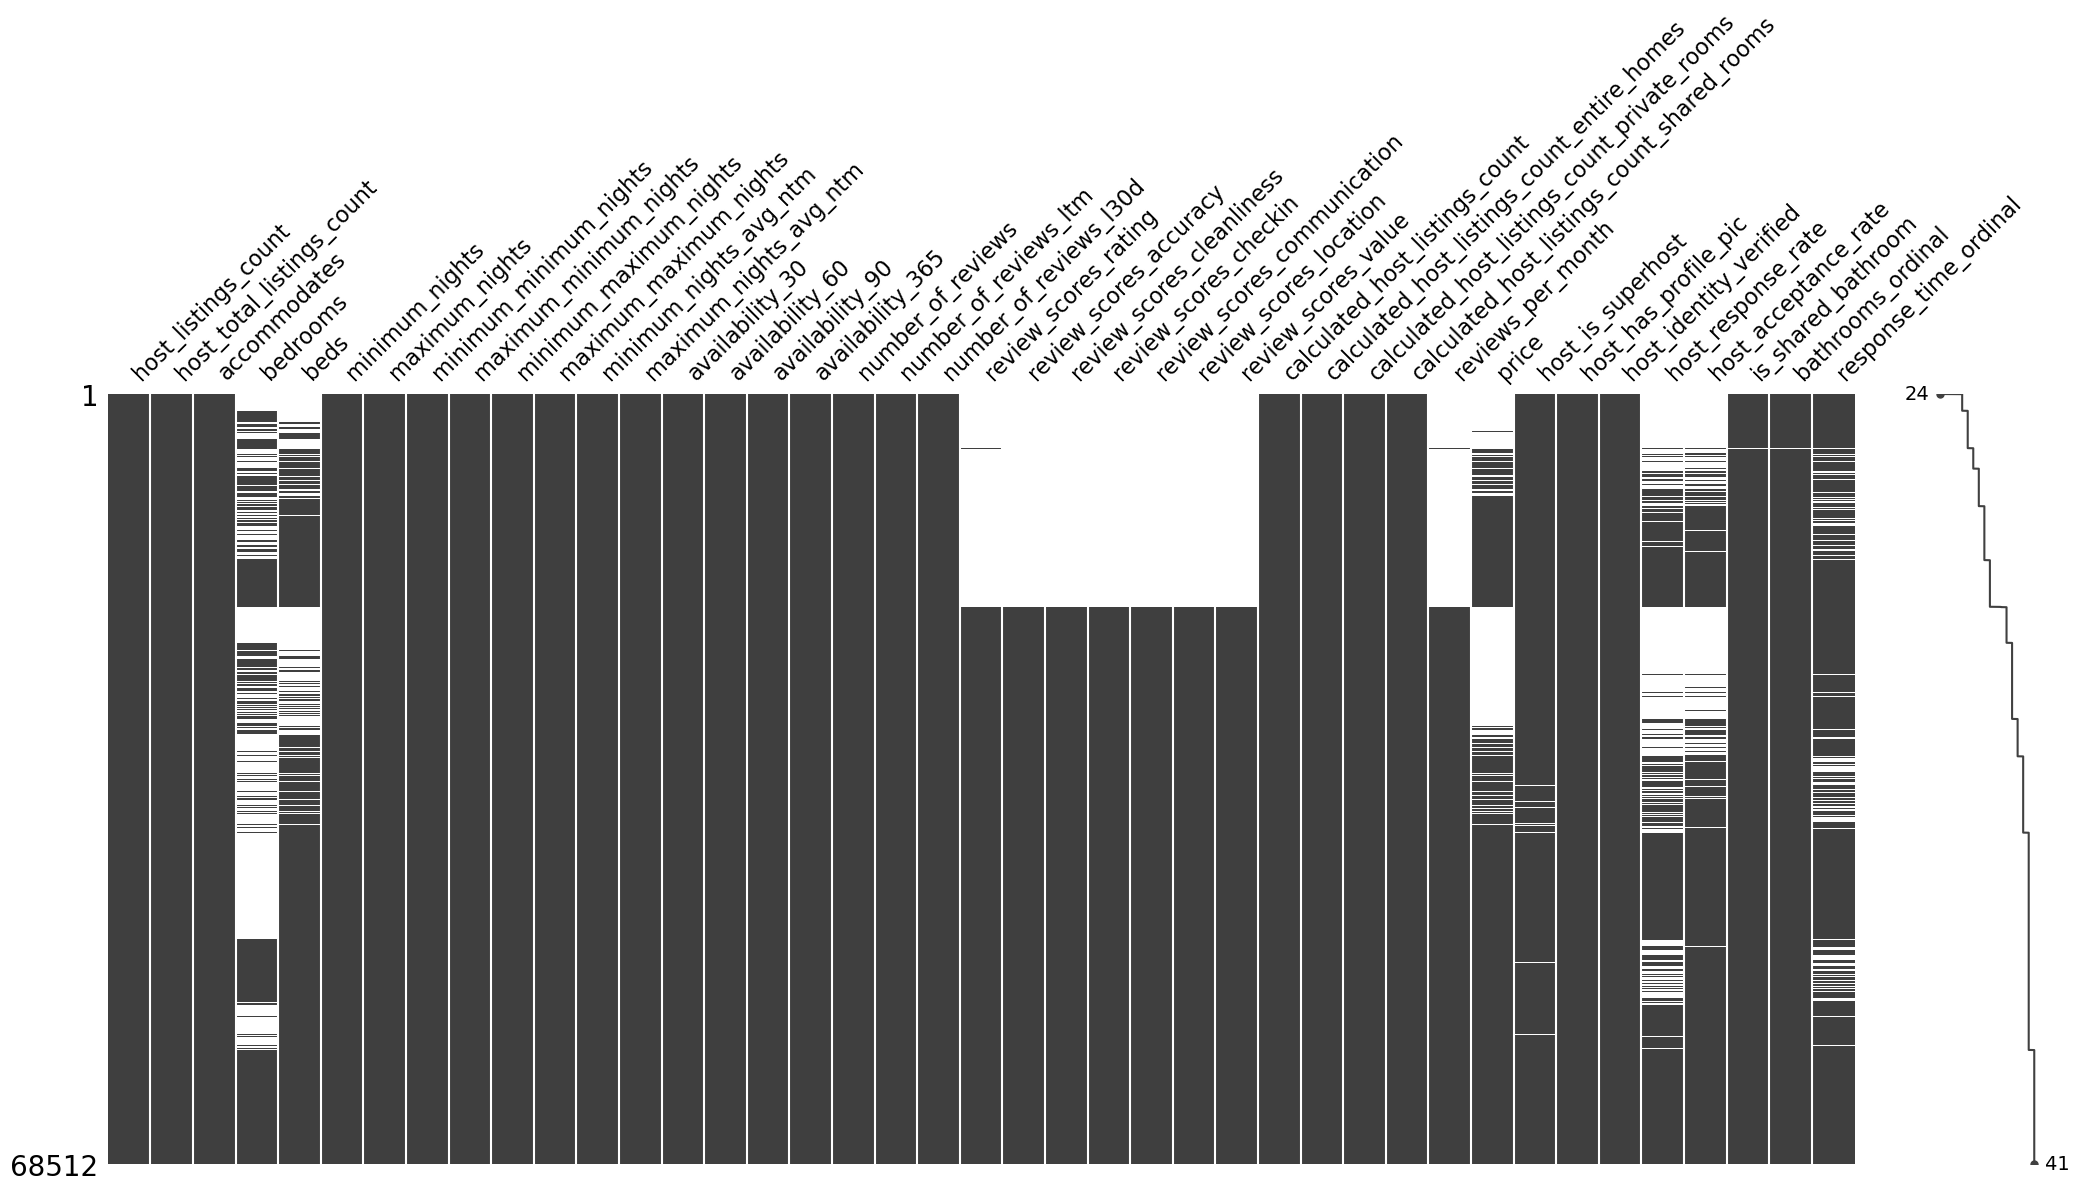

In [7]:
import missingno as msno

#Show the missing values in our dataset
#Missing values must be handled properly to run our Pearson Correlation Coefficient and Single Variable Regressor
display((correlation_df.isna().sum()/len(correlation_df)*100))
msno.matrix(correlation_df, sort='ascending')

In [8]:
feature = ['bathrooms_ordinal', 'bedrooms', 'beds', 'host_is_superhost']

for i in feature:
    feature_counts = correlation_df[i].value_counts().reset_index()
    feature_counts.columns = [i, 'Count']

    # Plot the counts of unique values for 'bathrooms'
    fig_1 = px.bar(feature_counts, x=i, y='Count', title='Number of ' + i + ' in Airbnbs')
    fig_1.update_xaxes(title=i)
    fig_1.update_yaxes(title='Count')
    fig_1.show()

In [9]:
# Calculate average host response/acceptance rate, and number of bedrooms and beds
# Inject average where cols are empt
cols_to_inject = ['host_response_rate', 'host_acceptance_rate', 'bedrooms', 'beds']

temp_data = correlation_df[cols_to_inject]
average_values = temp_data.dropna()[cols_to_inject].mean()
correlation_df['host_response_rate'].fillna(average_values[0], inplace=True)
correlation_df['host_acceptance_rate'].fillna(average_values[1], inplace=True)
correlation_df['bedrooms'].fillna(average_values[2], inplace=True)
correlation_df['beds'].fillna(average_values[3], inplace=True)

In [10]:
# Drop null/missing values from columns and validate no missing values exist
correlation_df = correlation_df.dropna()
display((correlation_df.isna().sum()/len(correlation_df)*100))

host_listings_count                             0.0
host_total_listings_count                       0.0
accommodates                                    0.0
bedrooms                                        0.0
beds                                            0.0
minimum_nights                                  0.0
maximum_nights                                  0.0
minimum_minimum_nights                          0.0
maximum_minimum_nights                          0.0
minimum_maximum_nights                          0.0
maximum_maximum_nights                          0.0
minimum_nights_avg_ntm                          0.0
maximum_nights_avg_ntm                          0.0
availability_30                                 0.0
availability_60                                 0.0
availability_90                                 0.0
availability_365                                0.0
number_of_reviews                               0.0
number_of_reviews_ltm                           0.0
number_of_re

In [11]:
from scipy.stats import pearsonr

#Calculate Pearson Correlation Coefficient by comparing other columns in df with review_scores_rating
comparison_df = correlation_df.drop('review_scores_rating', axis=1)
comparison_metrics = list(comparison_df)

pearson_coefficients = []
coef = []

#Base code for Pearson Correlation Coefficient retrieved and adapted from: https://ishanjainoffical.medium.com/understanding-pearson-correlation-bebdc9209885
for i in comparison_metrics:
    pearson_corr, p_value = pearsonr(correlation_df[i], correlation_df['review_scores_rating'])
    #print("\nResults: " + i)
    #print(f"Pearson Correlation Coefficient: {pearson_corr}")
    correlation_df['corr'] = pearson_corr
    coef.append(pearson_corr)
    result_string = f"{i}: {pearson_corr}"
    pearson_coefficients.append(result_string)

#Print results of the coefficients
pearson_coefficients.sort()
for i in pearson_coefficients:
    print(i + '\n')

print(sum(coef)/len(coef))

accommodates: 0.020891696819480235

availability_30: -0.08001915826146194

availability_365: -0.07590733499180131

availability_60: -0.08522462711815265

availability_90: -0.08290983123972516

bathrooms_ordinal: 0.033184132607759105

bedrooms: 0.031694227292582415

beds: 0.030313319624681527

calculated_host_listings_count: -0.10503690746233262

calculated_host_listings_count_entire_homes: -0.09257968896144436

calculated_host_listings_count_private_rooms: -0.046170634738760756

calculated_host_listings_count_shared_rooms: -0.0568482403977561

host_acceptance_rate: 0.02481095669380459

host_has_profile_pic: 0.018560866213108693

host_identity_verified: 0.0021224393925890774

host_is_superhost: 0.2683491216362454

host_listings_count: -0.07996277629295721

host_response_rate: 0.07262275922118697

host_total_listings_count: -0.08073749915241396

is_shared_bathroom: -0.04658368034002752

maximum_maximum_nights: -0.015804985392659142

maximum_minimum_nights: -0.029008929203337374

maximum_

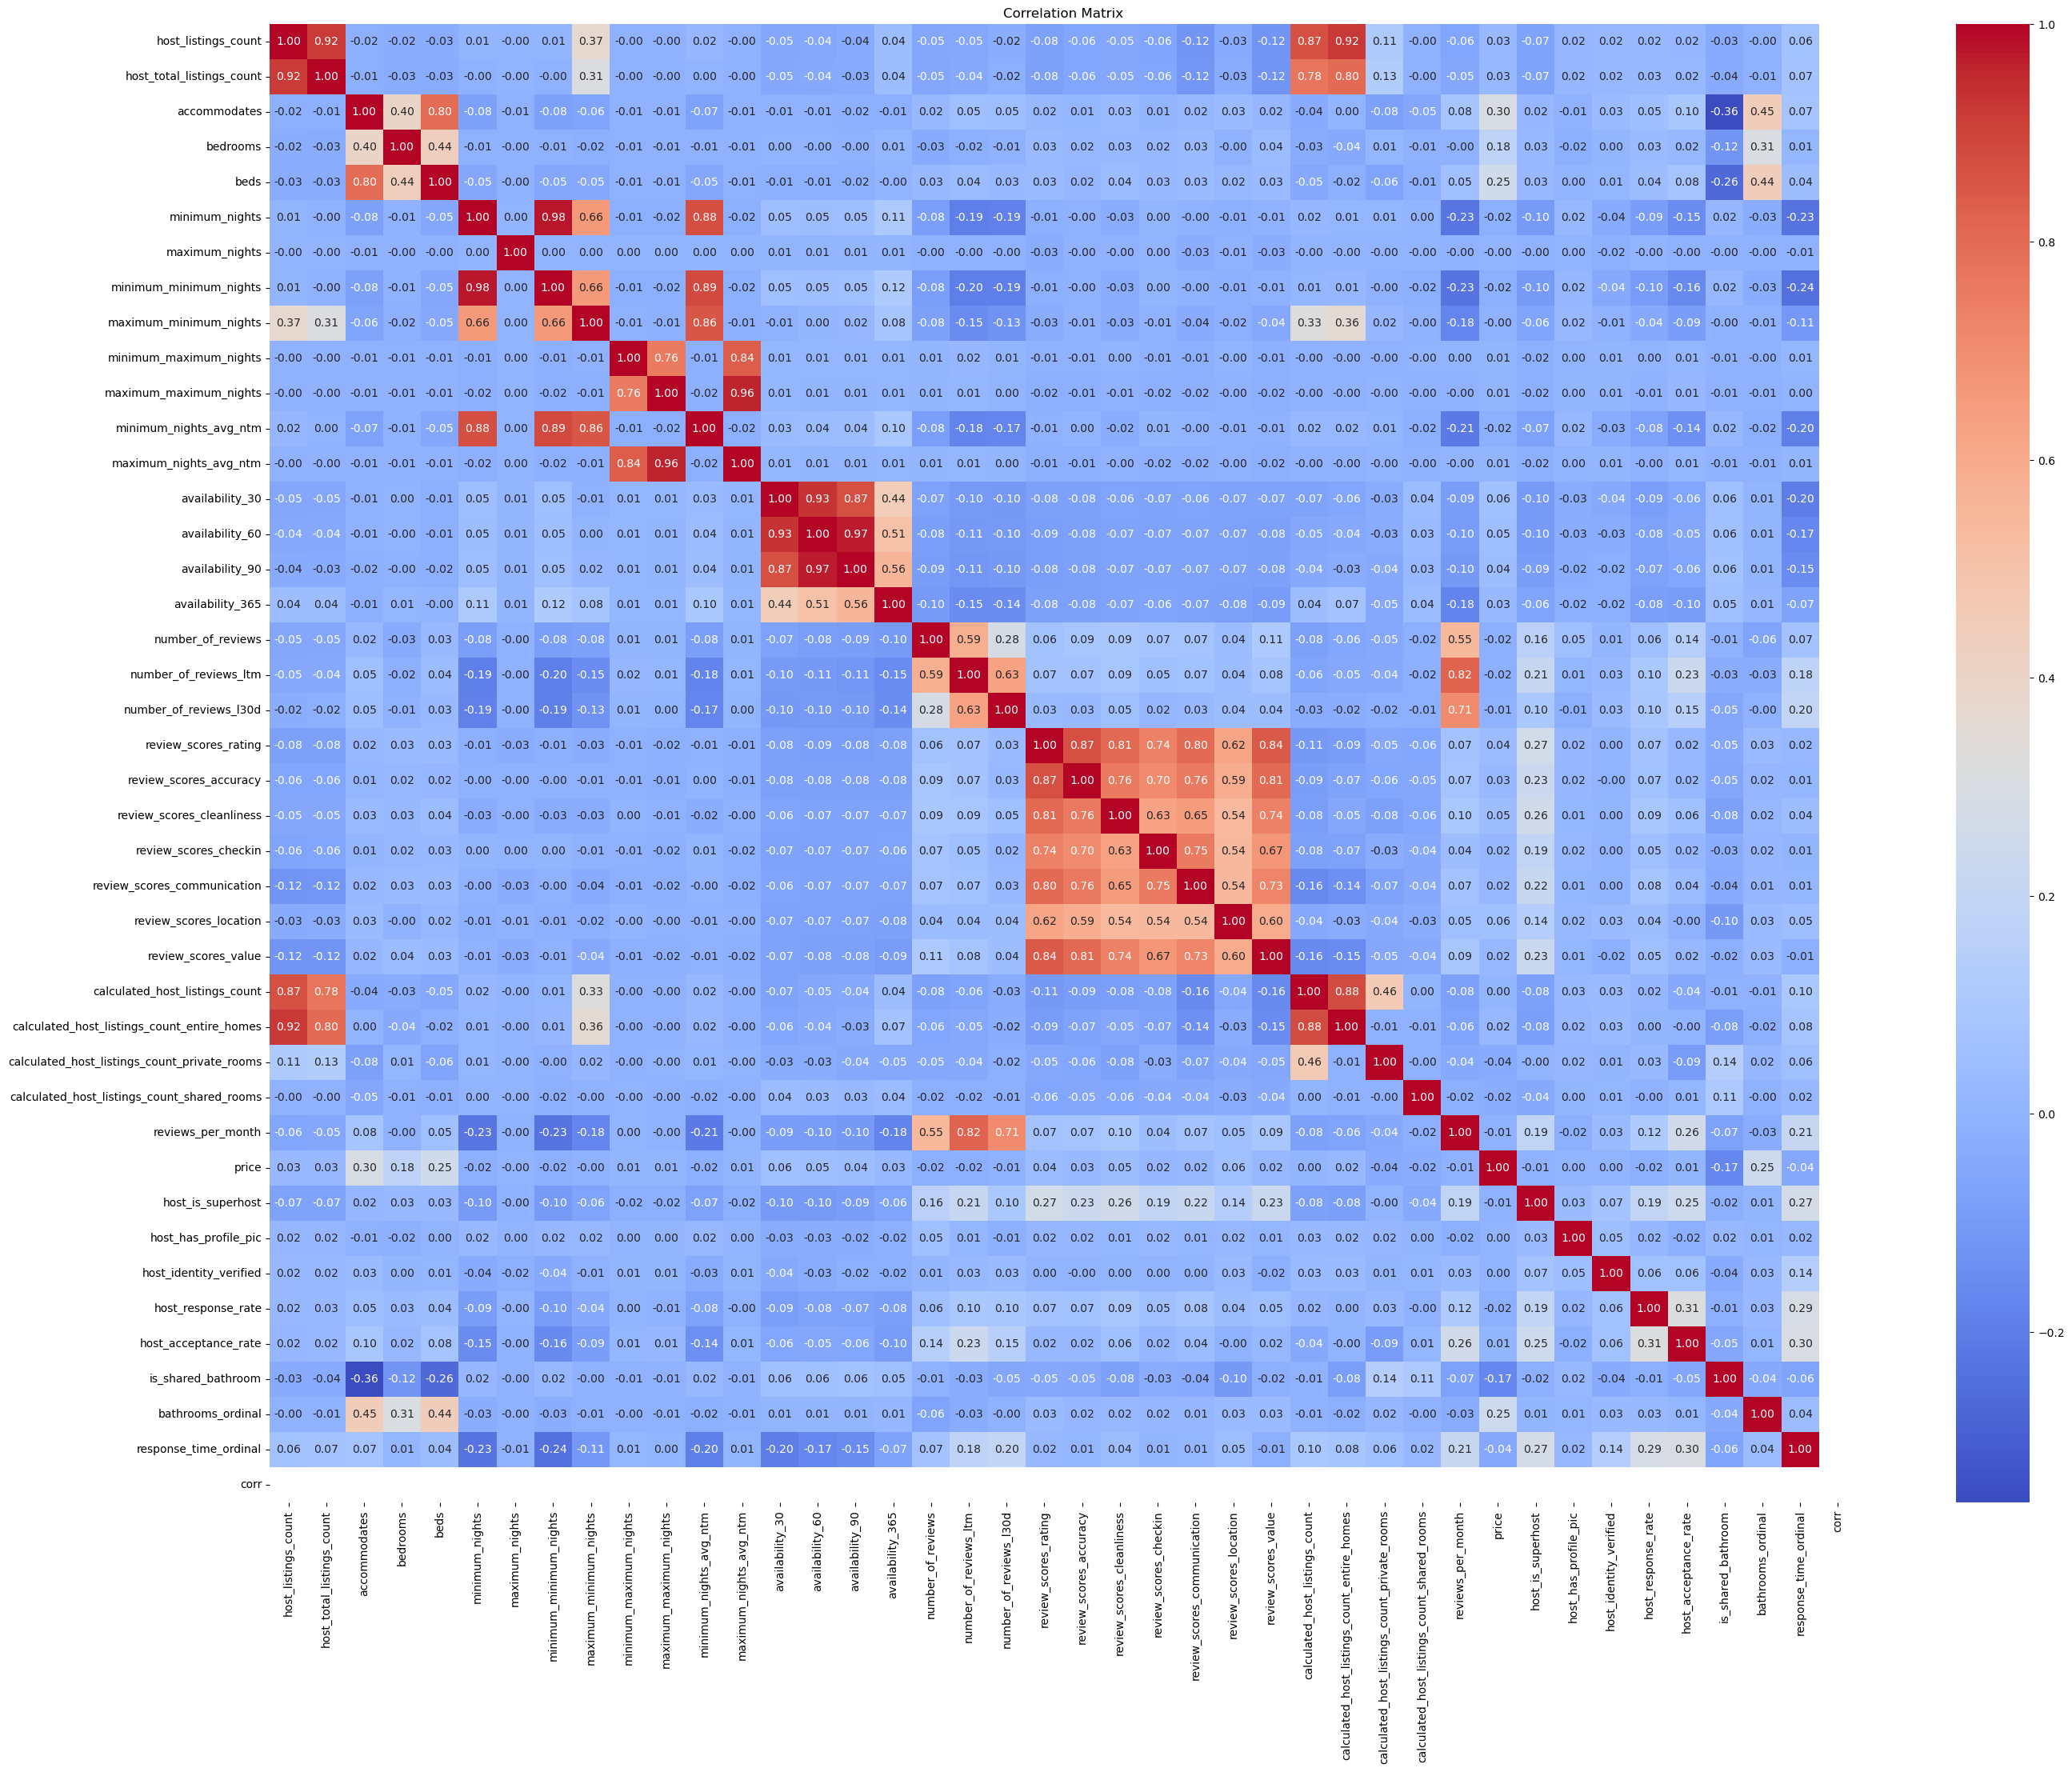

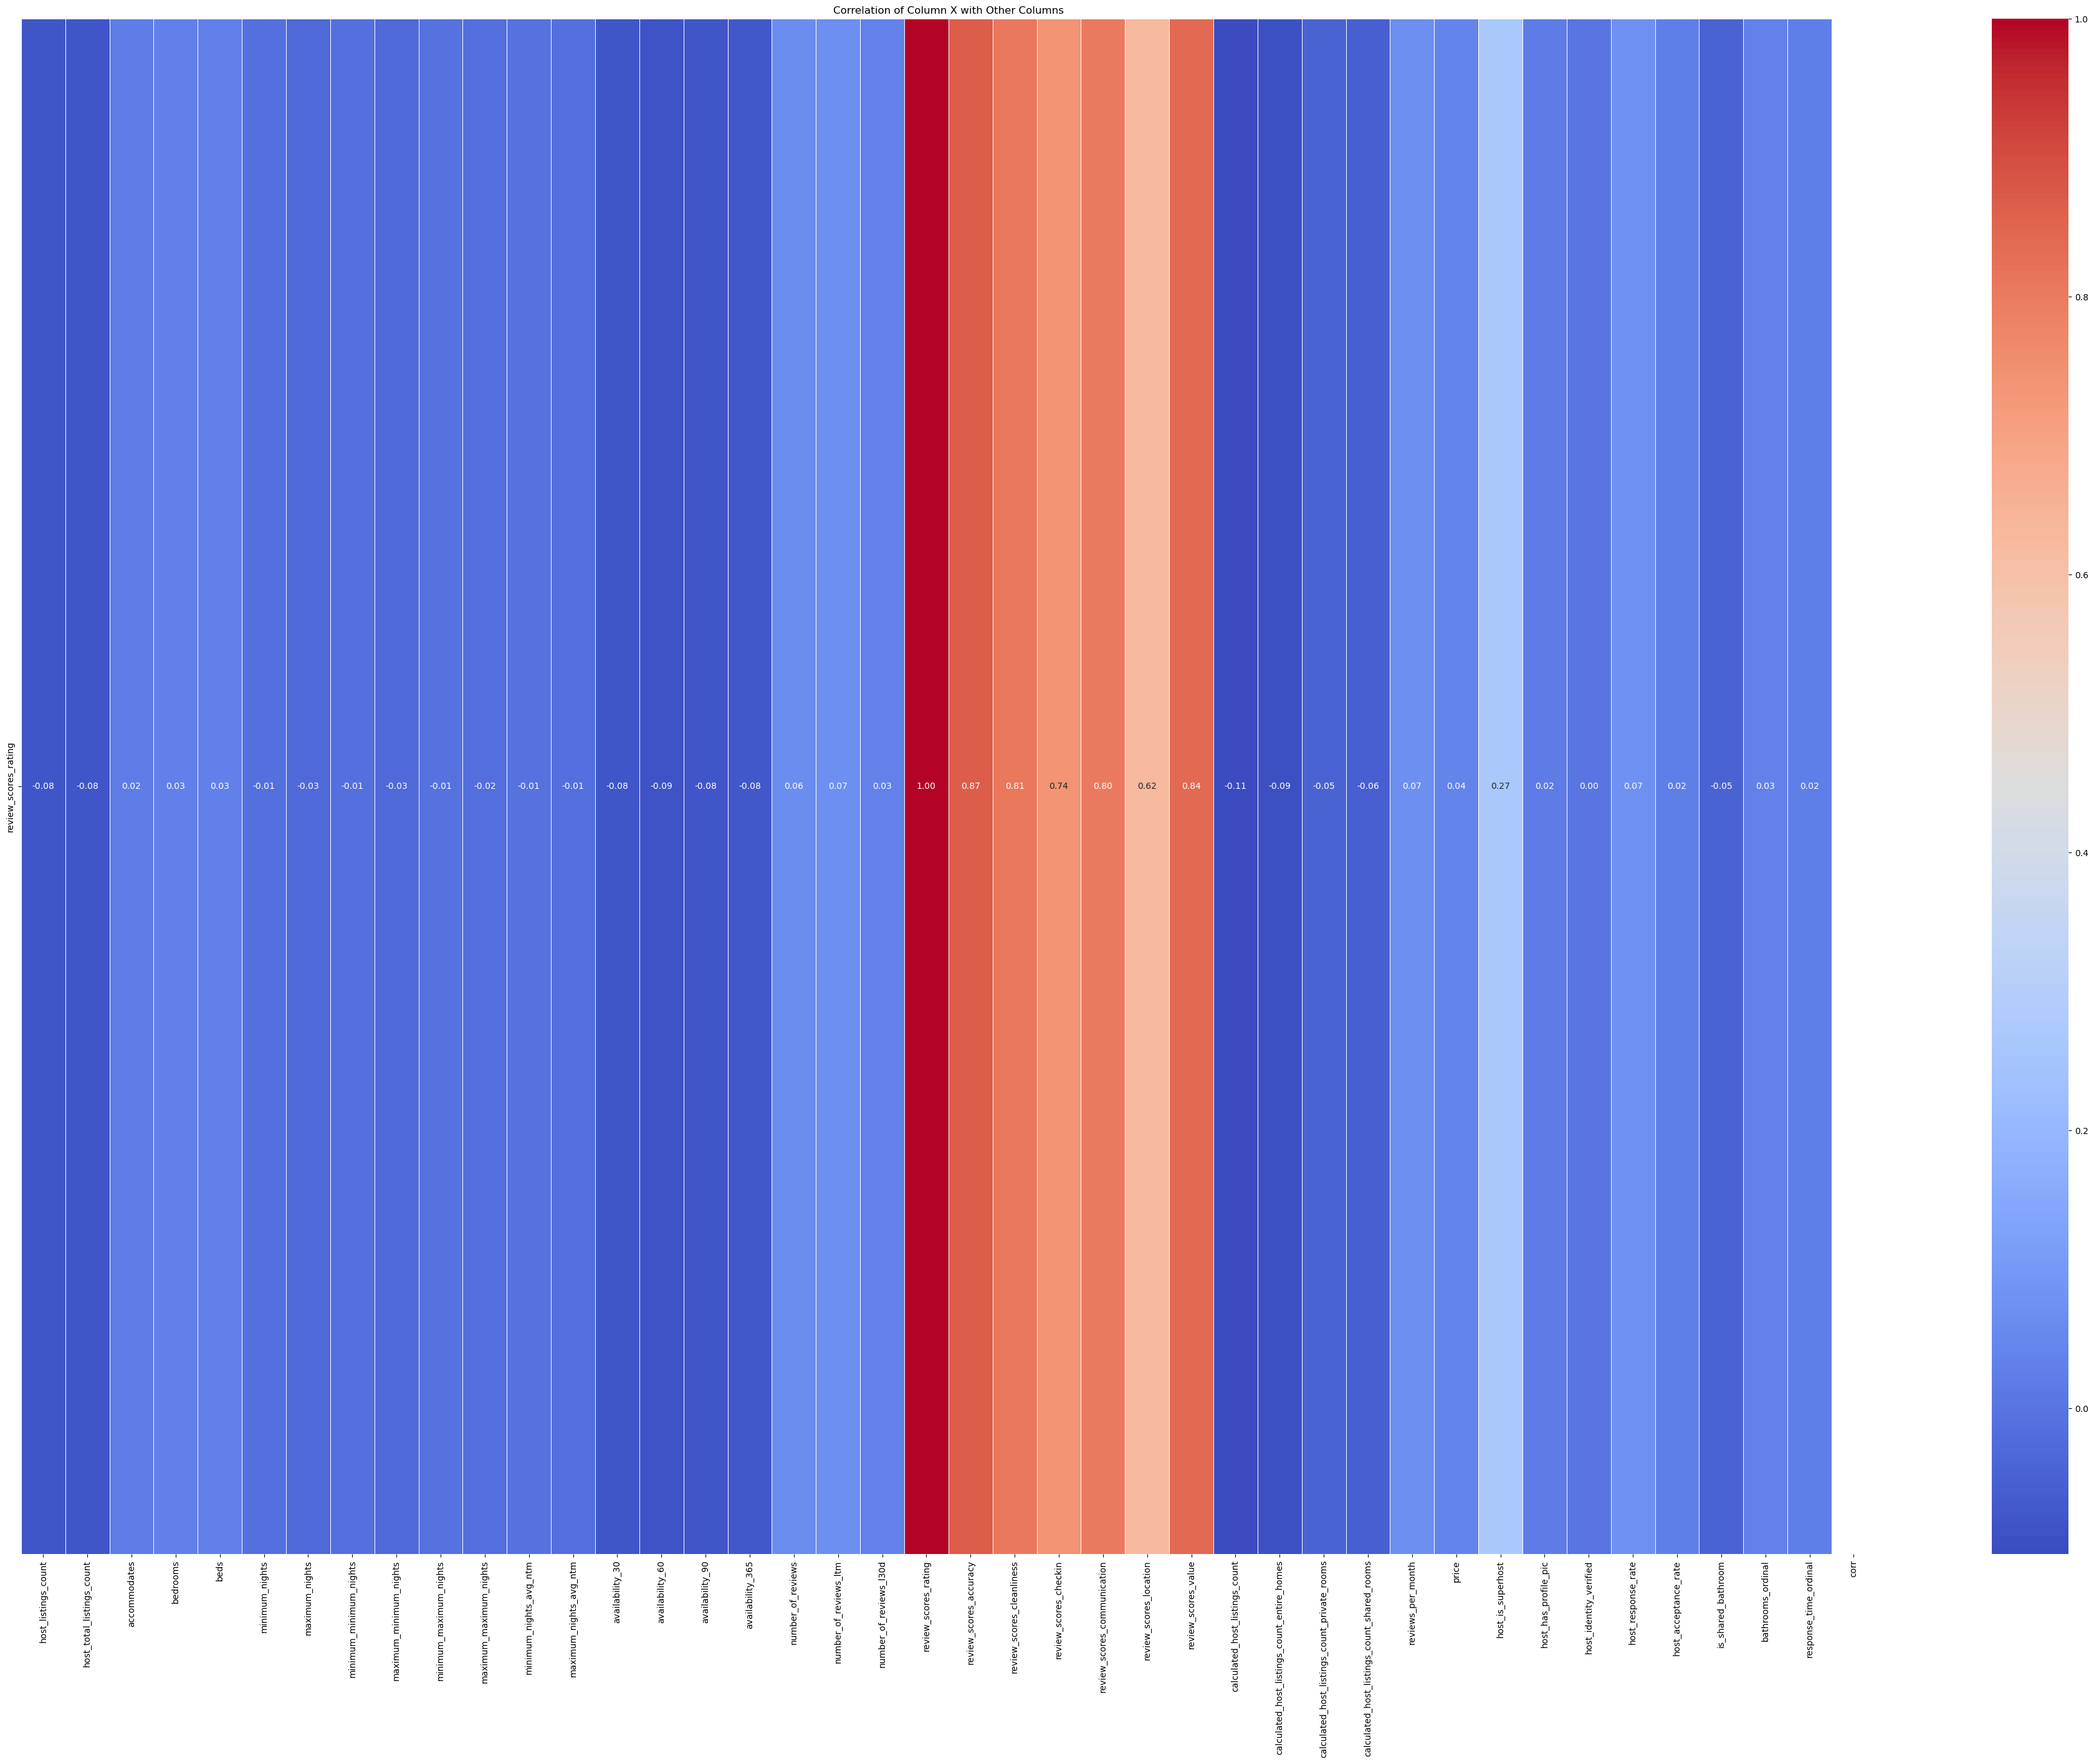

In [15]:
correlation = correlation_df.corr(method = 'pearson')

# Plot heatmap for Pearson Correlation Coefficient 
plt.figure(figsize=(32, 24))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

correlation_x = correlation_df.corr(method='pearson')['review_scores_rating']

# Plot heatmap for Pearson Correlation Coefficient for just 'review_scores_rating'
plt.figure(figsize=(48, 32)) 
sns.heatmap(correlation_x.to_frame().T, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation of Column X with Other Columns')
plt.show()

In [16]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, r2_score

for i in comparison_df:
    # Base code for decision tree referenced and readapted from: https://towardsdatascience.com/machine-learning-basics-decision-tree-regression-1d73ea003fda
    X = correlation_df[i].values
    y = correlation_df['review_scores_rating'].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

    # Fitting Decision Tree Regression to the dataset
    regressor = DecisionTreeRegressor()
    regressor.fit(X_train.reshape(-1,1), y_train.reshape(-1,1))

    y_pred = regressor.predict(X_test.reshape(-1,1))
    y_pred
    
    # Calculate metrics to determine accuracy and error rate
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test,y_pred)
    # Print results
    print (i)
    print("Mean Absolute Error " + str(mae))
    print("Mean Squared Error " + str(mse))
    print("r2 score " + str(r2) + '\n')


host_listings_count
Mean Absolute Error 0.2390125685420986
Mean Squared Error 0.1638935381366205
r2 score 0.040342548629623165

host_total_listings_count
Mean Absolute Error 0.23895979488819807
Mean Squared Error 0.17094432802598167
r2 score 0.0654046880467467

accommodates
Mean Absolute Error 0.25199878249897734
Mean Squared Error 0.1864076380367659
r2 score -0.000389117556805596

bedrooms
Mean Absolute Error 0.2543507963763747
Mean Squared Error 0.2031958961951403
r2 score 0.002072304223958099

beds
Mean Absolute Error 0.2571092451452944
Mean Squared Error 0.2026043285155558
r2 score 0.0011082659174082021

minimum_nights
Mean Absolute Error 0.25059553157498576
Mean Squared Error 0.1841334257088388
r2 score -0.0012007464719461236

maximum_nights
Mean Absolute Error 0.2532513948582828
Mean Squared Error 0.19636980076825028
r2 score -0.0005227900423505627

minimum_minimum_nights
Mean Absolute Error 0.2506120618571022
Mean Squared Error 0.18444505779942733
r2 score 0.0034241977229194642
